# Twitter sentiment analysis with TFIDF Vectorizer

In [1]:

# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en.examples import sentences 
from spacy.cli import download  
from bs4 import BeautifulSoup
# download("en_core_web_sm")
import spacy
import preprocess_kgptalkie as ps  # import the cleaning package
import re  # regex
from dython.model_utils import metric_graph
from dython.nominal import associations
from wordcloud import WordCloud
# from sklearn import set_config
# set_config(display="diagram")
from sklearn import set_config
set_config(display="diagram")
import plotly.express as px
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
# reading the csv file
df = pd.read_csv("airline_tweets.csv")
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [3]:
df.shape

(14640, 15)

In [4]:
df = df.loc[:,["airline","text","airline_sentiment"]] # rassigning df
df.head()

,airline,text,airline_sentiment
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral
1,Virgin America,@VirginAmerica plus you've added commercials t...,positive
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,neutral
3,Virgin America,@VirginAmerica it's really aggressive to blast...,negative
4,Virgin America,@VirginAmerica and it's a really big bad thing...,negative


In [5]:
df["sentiment_encoded"] = df.airline_sentiment.apply(lambda x: (-1) if x == "negative" else (0) if x == "neutral" else (1) )

In [6]:
df[df.duplicated().values]

,airline,text,airline_sentiment,sentiment_encoded
331,Virgin America,@VirginAmerica Thanks!,positive,1
515,United,@united thanks,positive,1
1477,United,@united thank you!,positive,1
1864,United,@united thank you,positive,1
1938,United,@united thank you,positive,1
...,...,...,...,...
13995,American,@AmericanAir 800 number will not even let you...,negative,-1
14386,American,@AmericanAir I want to speak to a human being!...,negative,-1
14392,American,@AmericanAir no response to DM or email yet. ...,negative,-1
14543,American,@AmericanAir should reconsider #usairways acqu...,negative,-1


In [7]:
df.drop_duplicates(keep ="first", inplace= True)

In [8]:
df.duplicated().sum()

0

In [9]:
df.rename({"text" :"tweets"}, axis =1, inplace = True)

In [10]:
df.isna().sum()

airline              0
tweets               0
airline_sentiment    0
sentiment_encoded    0
dtype: int64

In [11]:
df.dropna(how = "any", inplace = True)

In [12]:
df.shape
df.head()

,airline,tweets,airline_sentiment,sentiment_encoded
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral,0
1,Virgin America,@VirginAmerica plus you've added commercials t...,positive,1
2,Virgin America,@VirginAmerica I didn't today... Must mean I n...,neutral,0
3,Virgin America,@VirginAmerica it's really aggressive to blast...,negative,-1
4,Virgin America,@VirginAmerica and it's a really big bad thing...,negative,-1


In [13]:
df.airline_sentiment.value_counts().index


Index(['negative', 'neutral', 'positive'], dtype='object')

In [14]:
fig= px.pie(df.airline_sentiment.value_counts(), values = df.airline_sentiment.value_counts().values, names =df.airline_sentiment.value_counts().index)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Preprocessing and removing stopwords

In [15]:
# def get_clean(x):
#     x = str(x).lower().replace('\\', '').replace('_', ' ')
#     x = ps.cont_exp(x)
#     x = ps.remove_emails(x)
#     x = ps.remove_urls(x)
#     x = ps.remove_html_tags(x)
#     x = ps.remove_rt(x)
#     x = ps.remove_accented_chars(x)
#     x = ps.remove_special_chars(x)
#     x = re.sub("(.)\\1{2,}", "\\1", x)
#     return x


# #cleaning the tweets
# def remove_pattern(input_txt, pattern):
#     r = re.findall(pattern, input_txt)
#     for i in r:
#         input_txt = re.sub(i, '', input_txt)        
#     return input_txt
# def clean_tweets(tweets):
#     #remove twitter Return handles (RT @xxx:)
#     tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
#     #remove twitter handles (@xxx)
#     tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
#     #remove URL links (httpxxx)
#     tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
#     #remove special characters, numbers, punctuations (except for #)
#     tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
#     return tweets

from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [16]:
df.tweets = df.tweets.apply(lambda x: tweet_cleaner(x))

c:\Users\godwi\anaconda3\envs\ML\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [17]:
# Tokenization
tk = word_tokenize
df['tweets'].apply(tk)

0                                             [what, said]
1        [plus, you, ve, added, commercials, to, the, e...
2        [i, didn, t, today, must, mean, i, need, to, t...
3        [it, s, really, aggressive, to, blast, obnoxio...
4        [and, it, s, a, really, big, bad, thing, about...
                               ...                        
14635    [thank, you, we, got, on, a, different, flight...
14636    [leaving, over, minutes, late, flight, no, war...
14637    [please, bring, american, airlines, to, blackb...
14638    [you, have, my, money, you, change, my, flight...
14639    [we, have, ppl, so, we, need, know, how, many,...
Name: tweets, Length: 14452, dtype: object

In [18]:
stop_words = set(stopwords.words('english'))

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df['tweets'] = df['tweets'].apply(lambda x:cleaning_stopwords(x) )
df.head()

,airline,tweets,airline_sentiment,sentiment_encoded
0,Virgin America,said,neutral,0
1,Virgin America,plus added commercials experience tacky,positive,1
2,Virgin America,today must mean need take another trip,neutral,0
3,Virgin America,really aggressive blast obnoxious entertainmen...,negative,-1
4,Virgin America,really big bad thing,negative,-1


In [19]:
tweets= df.tweets.str.split(expand = True,n=1)[1]
df.tweets= tweets
df.isna().sum()

airline                0
tweets               406
airline_sentiment      0
sentiment_encoded      0
dtype: int64

In [20]:
df.tweets

0                                                     None
1                       added commercials experience tacky
2                         must mean need take another trip
3        aggressive blast obnoxious entertainment guest...
4                                            big bad thing
                               ...                        
14635                         got different flight chicago
14636    minutes late flight warnings communication min...
14637                   bring american airlines blackberry
14638    change flight answer phones suggestions make c...
14639    need know many seats next flight plz put us st...
Name: tweets, Length: 14452, dtype: object

In [21]:
# view sample cleaned text
df.dropna(inplace= True)
df.isna().sum()

airline              0
tweets               0
airline_sentiment    0
sentiment_encoded    0
dtype: int64

In [22]:
df.to_csv("dataframe.csv", index = False)

In [23]:
X= df.tweets
y= df.sentiment_encoded

# Pipeline with needed libraries

In [24]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import MultinomialNB

In [25]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [26]:
model = Pipeline([('Vect',TfidfVectorizer(max_features = 100000, ngram_range =(1,2),stop_words = 'english')),
                  #('to_dense', DenseTransformer()), 
                   ('mnb', MultinomialNB(alpha=0.02))
                 
                  ])

In [27]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [28]:
model.fit(X_train, y_train)

Pipeline(steps=[('Vect',
                 TfidfVectorizer(max_features=100000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('mnb', MultinomialNB(alpha=0.02))])

In [29]:
y_pred = model.predict(X_test )
y_pred

array([-1, -1, -1, ...,  0, -1, -1], dtype=int64)

In [30]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [31]:
accuracy_score(y_test, y_pred)

0.7284697508896797

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.91      0.83      1818
           0       0.56      0.37      0.44       569
           1       0.66      0.42      0.51       423

    accuracy                           0.73      2810
   macro avg       0.66      0.57      0.60      2810
weighted avg       0.71      0.73      0.71      2810



In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.91      0.83      1818
           0       0.56      0.37      0.44       569
           1       0.66      0.42      0.51       423

    accuracy                           0.73      2810
   macro avg       0.66      0.57      0.60      2810
weighted avg       0.71      0.73      0.71      2810



In [34]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1660,  111,   47],
       [ 313,  210,   46],
       [ 189,   57,  177]], dtype=int64)

In [35]:
pd.DataFrame(cm)

,0,1,2
0,1660,111,47
1,313,210,46
2,189,57,177


<AxesSubplot:>

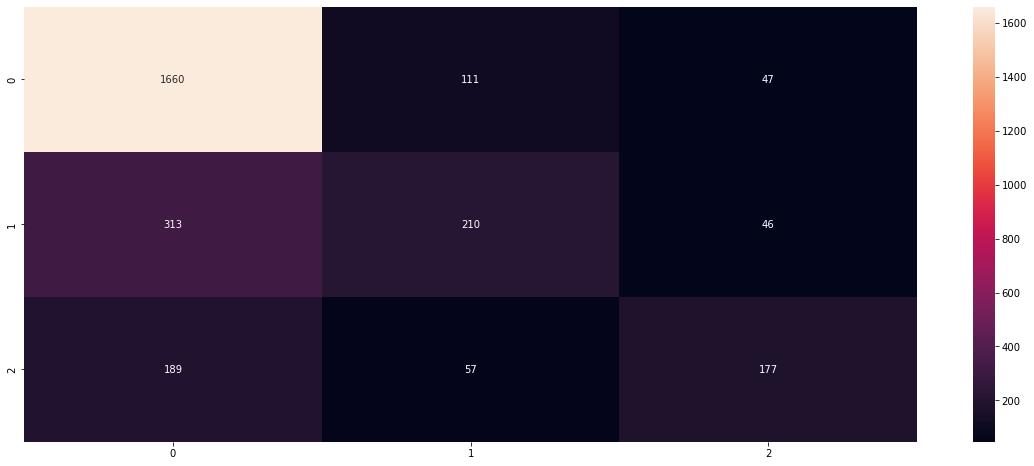

In [36]:
fig, ax = plt.subplots(figsize = (20,8))
sns.heatmap(cm, annot = True, fmt = "d",)

In [37]:
y_proba = model.predict_proba(X_test)
y_proba

array([[0.86912458, 0.02127995, 0.10959546],
       [0.91372042, 0.04441355, 0.04186603],
       [0.98903727, 0.00706288, 0.00389985],
       ...,
       [0.13225516, 0.86430985, 0.003435  ],
       [0.53755184, 0.4292981 , 0.03315006],
       [0.97900899, 0.01733   , 0.003661  ]])

In [38]:
import joblib
joblib.dump(model,"model_twitter.joblib")

['model_twitter.joblib']

In [39]:
df

,airline,tweets,airline_sentiment,sentiment_encoded
1,Virgin America,added commercials experience tacky,positive,1
2,Virgin America,must mean need take another trip,neutral,0
3,Virgin America,aggressive blast obnoxious entertainment guest...,negative,-1
4,Virgin America,big bad thing,negative,-1
5,Virgin America,would pay flight seats playing really bad thin...,negative,-1
...,...,...,...,...
14635,American,got different flight chicago,positive,1
14636,American,minutes late flight warnings communication min...,negative,-1
14637,American,bring american airlines blackberry,neutral,0
14638,American,change flight answer phones suggestions make c...,negative,-1


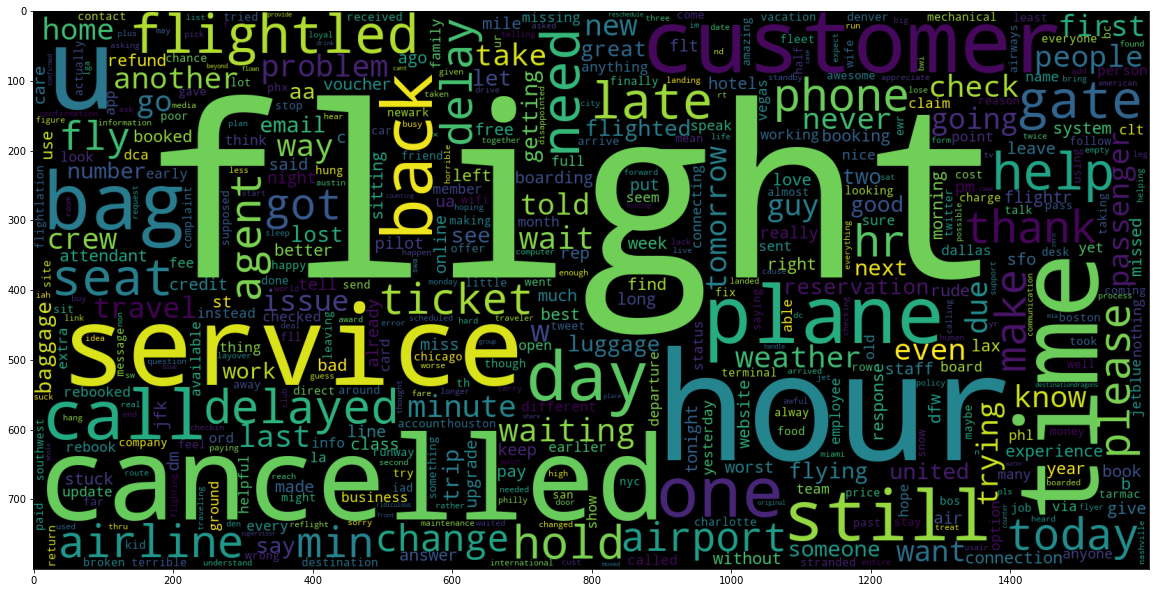

In [40]:
text = "".join(df['tweets'])
fig, ax = plt.subplots(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800,collocations=False).generate(text)
ax.imshow(wc);

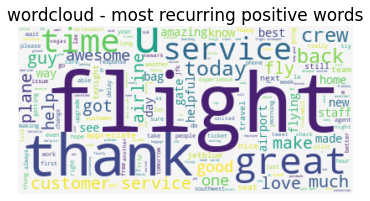

In [41]:
fig, ax = plt.subplots() 
super = df.loc[:,["tweets","airline_sentiment"]]
text = "".join(super[super.airline_sentiment == "positive"].tweets)
wc= WordCloud(max_words = 1000,background_color="whitesmoke", random_state=42,normalize_plurals=True).generate(text)
plt.title("wordcloud - most recurring positive words", fontsize = 17)
plt.axis("off")
#plt.tight_layout(pad=0)
ax.imshow(wc,interpolation="bilinear")


In [42]:
super = df.loc[:,["tweets","airline_sentiment"]]
super[super.airline_sentiment == "negative"].tweets

3        aggressive blast obnoxious entertainment guest...
4                                            big bad thing
5        would pay flight seats playing really bad thin...
15                                  pdx schedule still mia
17       nyc sfo last week fully sit seat due two large...
                               ...                        
14631    nothing getting us country back us broken plan...
14633    cancelled flightled leaving tomorrow morning a...
14634                                           cue delays
14636    minutes late flight warnings communication min...
14638    change flight answer phones suggestions make c...
Name: tweets, Length: 8990, dtype: object

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

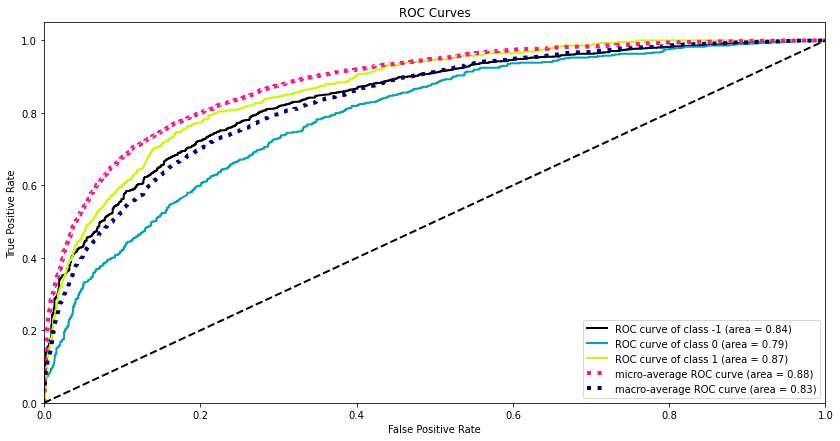

In [43]:
import scikitplot as skplt
fig, ax = plt.subplots(figsize=(14,7))
skplt.metrics.plot_roc(y_test, y_proba,ax= ax)

In [44]:
text = df['tweets'][:4]
text

1                   added commercials experience tacky
2                     must mean need take another trip
3    aggressive blast obnoxious entertainment guest...
4                                        big bad thing
Name: tweets, dtype: object